In [6]:
include("../src/NN.jl")
include("../util/datasets.jl")

using NN
using PyPlot


In [7]:
X,Y = mnistData(ttl=55000) # 0-1
println("X statistics: $(mean(X)) $(minimum(X)) $(maximum(X))")

# Y = round(Int, Y)
train_set, test_set, validation_set = datasplit(X,Y;ratio=10./11.)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]
println("TrainSet: $(size(trX)) $(size(trY))")
println("ValSet  : $(size(valX)) $(size(valY))")
println("TestSet : $(size(teX)) $(size(teY))")

trX  = permutedims(reshape(trX,  (size(trX,1),  1, 28, 28)), [3,4,2,1]);
valX = permutedims(reshape(valX, (size(valX,1), 1, 28, 28)), [3,4,2,1]);
teX  = permutedims(reshape(teX,  (size(teX,1),  1, 28, 28)), [3,4,2,1]);


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /Users/Grendel/.julia/v0.6/MNIST/src/MNIST.jl:88
 [4] #mnistData#12(::Int64, ::Function) at /Users/Grendel/Desktop/NN.jl/util/datasets.jl:52
 [5] (::#kw##mnistData)(::Array{Any,1}, ::#mnistData) at ./<missing>:0
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /Users/Grendel/.julia/v0.6/Compat/src/Compat.jl:464
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/Grendel/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/Grendel/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[7], in expression starting on line 1
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /Users/Grendel/.julia/v0.6

X statistics: 0.1302271924643437 0.0 0.99609375


In [8]:
function get_corr(pred, answ)
    N = size(answ, 1)
    C = size(answ, 2)
    corr = 0
    for i = 1:N
        if dot(answ[i,:], pred[i,:]) > 0
            corr += 1
        end
    end
    return corr
end

get_corr (generic function with 1 method)

In [9]:


function sgd(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 100, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    all_losses = []

    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        epo_cor = 0
        for bid = 0:(num_batch-1)
            time_used = @elapsed begin
                batch += 1
                local sidx::Int = convert(Int64, bid*batch_size+1)
                local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                local batch_X = X[:,:,:,sidx:eidx]
                local batch_Y = Y[sidx:eidx,:]
                loss, pred = forward(net, batch_X, batch_Y)
                backward(net, batch_Y)
                append!(all_losses, mean(loss))
                for i = 1:length(net.layers)
                    layer = net.layers[i]

                    param = getParam(layer)
                    if param == nothing
                        continue
                    end

                    gradi = getGradient(layer)
                    for j = 1:length(gradi)
                        param[j] -= lrSchedule(epo) * gradi[j] / batch_size
                    end
                    setParam!(layer, param)
                end

                # _, pred = forward(net, batch_X, batch_Y; deterministics = true)
                epo_cor  += get_corr(pred, batch_Y)
                local acc = get_corr(pred, batch_Y) / batch_size
            end
#             println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)

        # Run validation set
        v_ls, v_pd = forward(net, valX, valY)
        local v_loss = mean(v_ls)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pd, valY) / v_size
        append!(val_losses, v_loss)
        append!(val_accu,   v_accu)

        # if verbose > 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
        # end
    end
    return epo_losses,epo_accus, val_losses, val_accu, all_losses
end

function nestorove_momemtum(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    all_losses = []
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)
                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue
                        end
                        gradi = getGradient(layer)
                        veloc = getVelocity(layer)

                        for j = 1:length(param)
                            gradi[j] = lrSchedule(epo) * gradi[j] / batch_size
                            veloc[j] = veloc[j] * alpha - gradi[j]
                            param[j] = param[j] + alpha * veloc[j] - gradi[j]
                        end
                        setParam!(layer, param)
                    end

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu, all_losses
end

function adagrad(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = (x -> (x<7)?0.01:0.001), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    all_losses = []
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    cache = []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(cache, nothing)
        else
            c = []
            for j = 1:length(param)
                push!(c, zeros(size(param[j])))
            end
            push!(cache, c)
        end
    end;

    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            c = cache[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(c) == size(p) && size(c) == size(g)
                            c = c + g.^2
                            p = p - lrSchedule(epo) * g ./ (sqrt(c) + 1e-10)
                            cache[i][j] = c
                            param[j] =    p
                        end
                        setParam!(layer, param)
                    end

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu, all_losses
end

function RMSprop(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = 0.01,
    verbose=0, alpha::Float64 = 0.9)

    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    all_losses = []
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    cache = []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(cache, nothing)
        else
            c = []
            for j = 1:length(param)
                push!(c, zeros(size(param[j])))
            end
            push!(cache, c)
        end
    end;

    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            c = cache[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(c) == size(p) && size(c) == size(g)
                            c = c * alpha + g.^2 * (1 - alpha)
                            p = p - lrSchedule(epo) * g ./ (sqrt(c) + 1e-8)
                            cache[i][j] = c
                            param[j] =    p
                        end
                        setParam!(layer, param)
                    end

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu,all_losses
end

function Adam(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = 0.01,
    beta_1::Float64 = 0.9, beta_2::Float64 = 0.999, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    m_t, v_t = [], []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(m_t, nothing)
            push!(v_t, nothing)
        else
            c_1, c_2 = [], []
            for j = 1:length(param)
                push!(c_1, zeros(size(param[j])))
                push!(c_2, zeros(size(param[j])))
            end
            push!(m_t, c_1)
            push!(v_t, c_2)
        end;
    end;

    iter = 1 # number of iterations
    all_losses = []
    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            m = m_t[i][j]
                            v = v_t[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(m) == size(p) && size(m) == size(g) && size(m) == size(v)

                            # Moving average to approximate gradient with velocity
                            m = m * beta_1 + g    * (1 - beta_1)
                            v = v * beta_2 + g.^2 * (1 - beta_2)

                            # Compute the counter biased version of [m] and [v]
                            m_hat = m / (1. - beta_1^iter)
                            v_hat = v / (1. - beta_2^iter)

                            # Update gradients
                            p = p - lrSchedule(epo) * m_hat ./ (sqrt(v_hat) + 1e-4)

                            # store the things back
                            param[j] = p
                            m_t[i][j] = m
                            v_t[i][j] = v

                        end
                        setParam!(layer, param)
                    end
                    iter += 1

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu,all_losses
end

Adam (generic function with 1 method)

In [10]:
function AdamIsh(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = 0.01,
    beta_1::Float64 = 0.9, beta_2::Float64 = 0.999, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    m_t, v_t = [], []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(m_t, nothing)
            push!(v_t, nothing)
        else
            c_1, c_2 = [], []
            for j = 1:length(param)
                push!(c_1, zeros(size(param[j])))
                push!(c_2, zeros(size(param[j])))
            end
            push!(m_t, c_1)
            push!(v_t, c_2)
        end;
    end;

    iter = 1 # number of iterations
    all_losses = []
    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            m = m_t[i][j]
                            v = v_t[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(m) == size(p) && size(m) == size(g) && size(m) == size(v)

                            # Moving average to approximate gradient with velocity
                            if epo == 1 && bid == 0
                                m = g
                                v = g.^2
                            else
                                m = m * beta_1 + g    * (1 - beta_1)
                                v = v * beta_2 + g.^2 * (1 - beta_2)
                            end

                            # Compute the counter biased version of [m] and [v]
                            m_hat = m / (1. - beta_1^iter)
                            v_hat = v / (1. - beta_2^iter)

                            # Update gradients
                            p = p - lrSchedule(epo) * m_hat ./ (sqrt(v_hat) + 1e-4)

                            # store the things back
                            param[j] = p
                            m_t[i][j] = m
                            v_t[i][j] = v

                        end
                        setParam!(layer, param)
                    end
                    iter += 1

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu,all_losses
end

AdamIsh (generic function with 1 method)

In [11]:
batch_size = 500

function build_cnn()
    layers = Layer[
        InputLayer((28,28,1,batch_size)),
        CaffeConvLayer(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        CaffeConvLayer(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        FlattenLayer(),

        DenseLayer(256),
        ReLu(),

        DropoutLayer(0.5),
        DenseLayer(10)
    ]

    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end

build_cnn (generic function with 1 method)

In [ ]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, adam_losses = Adam(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(adam_losses), adam_losses)
title("Adam : Training losses")
show()



Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] exp(::Array{Float64,2}) at ./deprecated.jl:57
 [3] #forward#28(::Array{Any,1}, ::Function, ::NN.SoftMaxCrossEntropyLoss, ::Array{Float64,2}, ::Array{Float64,2}) at /Users/Grendel/Desktop/NN.jl/src/layers/SoftMaxCrossEntropy.jl:57
 [4] forward(::NN.SoftMaxCrossEntropyLoss, ::Array{Float64,2}, ::Array{Float64,2}) at /Users/Grendel/Desktop/NN.jl/src/layers/SoftMaxCrossEntropy.jl:51
 [5] #forward#38(::Array{Any,1}, ::Function, ::NN.SequentialNet, ::Array{Float64,4}, ::Array{Float64,2}) at /Users/Grendel/Desktop/NN.jl/src/layers/SequentialNet.jl:24
 [6] macro expansion at ./In[9]:361 [inlined]
 [7] macro expansion at ./util.jl:293 [inlined]
 [8] macro expansion at ./In[9]:355 [inlined]
 [9] macro expansion at ./util.jl:293 [inlined]
 [10] #Adam#37(::Int64, ::Int64, ::##45#46, ::Float64, ::Float64, ::Int64, ::Function, ::NN.SequentialNet, ::Tuple{Array{Float64,4},Array{Float64,2}}, ::Tuple{Array{Float64,4},Array{Float64,

In [ ]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, rmsprop_losses = RMSprop(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(rmsprop_losses), rmsprop_losses)
title("RMS Prop : Training losses")
show()


In [ ]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, adagrad_losses = adagrad(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(adagrad_losses), adagrad_losses)
title("Adagrad : Training losses")
show()



In [ ]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, nest_momemtum_losses = nestorove_momemtum(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.01, verbose=1
)

figure(figsize=(12,6))
plot(1:length(nest_momemtum_losses), nest_momemtum_losses)
title("Nestorove Momemtum : Training losses")
show()


In [ ]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, sgd_losses = sgd(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.01, verbose=1
)

figure(figsize=(12,6))
plot(1:length(sgd_losses), sgd_losses)
title("SGD : Training losses")
show()

In [ ]:
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, adamish_losses = AdamIsh(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(adamish_losses), adamish_losses)
title("AdamIsh : Training losses")
show()



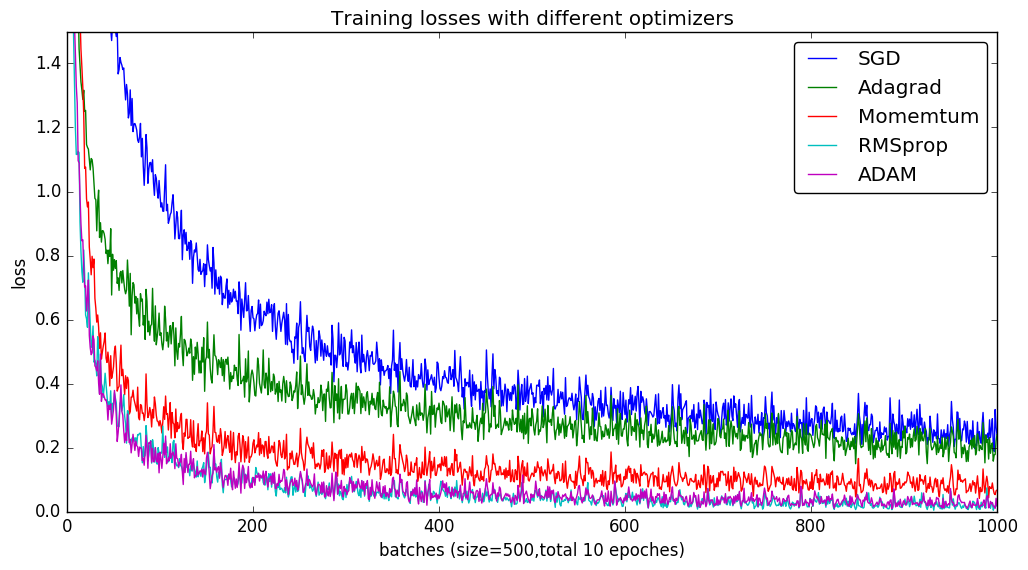

In [35]:
figure(figsize=(12,6))
plot(1:length(sgd_losses), sgd_losses,       label="SGD")
plot(1:length(adagrad_losses), adagrad_losses, label="Adagrad")
plot(1:length(nest_momemtum_losses), nest_momemtum_losses; label="Momemtum")
plot(1:length(rmsprop_losses), rmsprop_losses, label="RMSprop")
plot(1:length(adam_losses), adam_losses,       label="ADAM")
ylim([0, 1.5])
xlabel("batches (size=500,total 10 epoches)")
ylabel("loss")
title("Training losses with different optimizers")
legend(loc="upper right",fancybox="true")
savefig("optimizers.png")
show()